# Projet MLOps: Segmentation des clients Olist

## Notebook 2: Modèles

Dans le premier notebook nous avons eu à effectuer l'analyse exploratoire des données ainsi que le feature engineering afin de créer un jeu de données que nous pourrons utiliser pour faire notre segmentation.</br> Dans ce notebook nous allons donc procéder à la segmentation des clients</br>

En utilisant les résultats de cette segmentatiom, l'équipe marketing d'Olist pourra maximiser l'efficacité de ses campagnes et améliorer l'engagement et la satisfaction des clients.

<img src="https://media.licdn.com/dms/image/D5612AQEbR-vj1LqUFw/article-cover_image-shrink_600_2000/0/1693362637757?e=2147483647&v=beta&t=yD-EP9-YR-_gitRaxxiAGd5jzvvlnrjyzuSgVfXYDQY" alt="dataset_configuration" width="1200"/>

## Import des bibliothèques

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
import warnings
import mlflow
import pandas as pd
import numpy as np
import pendulum
import matplotlib.pyplot as plt
import seaborn as sns

from mlflow.tracking import MlflowClient
from loguru import logger
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from mlflow.models.signature import infer_signature
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import pickle

sys.path.append(str(Path.cwd().parent))
from settings.params import PARAMS
from src.load_dataset import load_data

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 25)
warnings.filterwarnings("ignore")

In [2]:
# Set logging format
log_fmt = (
    "<blue>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</blue> | "
    "<level>{level: <8}</level> | "
    "<green>{name}</green>:<magenta>{function}</magenta>:<yellow>{line}</yellow> | "
    "<cyan>Thread: {thread.name}</cyan> | "
    "<white>PID: {process}</white> - {message}"
)
logger.configure(handlers=[{'sink': sys.stderr, 'format': log_fmt}])

# Current date
CURRENT_DATE = pendulum.now(tz="UTC")

# Directories
PROJECT_DIR = Path.cwd().parent
OUTPUTS_DIR = Path(PROJECT_DIR, "output_files")
API_DIR = Path(PROJECT_DIR, "API")

logger.info(f"Project directory: {PROJECT_DIR}, Outputs directory: {OUTPUTS_DIR}, API directory: {API_DIR}")

2024-08-09 16:14:44.211 | INFO     | __main__:<module>:19 | Thread: MainThread | PID: 49869 - Project directory: /Users/massamba/Desktop/MLOps/projet_mlops, Outputs directory: /Users/massamba/Desktop/MLOps/projet_mlops/output_files, API directory: /Users/massamba/Desktop/MLOps/projet_mlops/API


## Entrainement et Tracking

In [3]:
df_rfm = load_data(f"{OUTPUTS_DIR}/segmentation_01_analyse_rfm_dataset.csv")

2024-08-09 16:14:44.233 | INFO     | src.load_dataset:load_data:17 | Thread: MainThread | PID: 49869 - Dataset path to load /Users/massamba/Desktop/MLOps/projet_mlops/output_files/segmentation_01_analyse_rfm_dataset.csv
2024-08-09 16:14:44.327 | INFO     | src.load_dataset:load_data:27 | Thread: MainThread | PID: 49869 - Data shape: (93811, 9)


                 customer_unique_id  total_spent  frequency  avg_installments  \
0  0000366f3b9a7992bf8c76cfdf3221e2       129.90          1               8.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        18.90          1               1.0   
2  0000f46a3911fa3c0805444483337064        69.00          1               8.0   
3  0000f6ccb0745a6a4b88665a16c9f078        25.99          1               4.0   
4  0004aac84e0df4da2b147fca70cf8255       180.00          1               6.0   
5  0004bd2a26a76fe21f786e4fbd80607f       154.00          1               8.0   
6  00050ab1314c0e55a6ca13cf7181fecf        27.99          1               1.0   
7  00053a61a98854899e70ed204dd4bafe       382.00          2               3.0   
8  0005e1862207bf6ccc02e4228effd9a0       135.00          1               3.0   
9  0005ef4cd20d2893f0d9fbd94d3c0d97       104.90          1               4.0   

   total_items  payment_price_ratio  recency  avg_fractional_payment_ratio  \
0          1.0             1.0

### Détermination du nombre de clusters optimal pour chaque modèle

In [4]:
X = df_rfm.drop("customer_unique_id", axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = PCA(n_components=0.95)
X_transformed = model.fit_transform(X_scaled)

#### KMeans

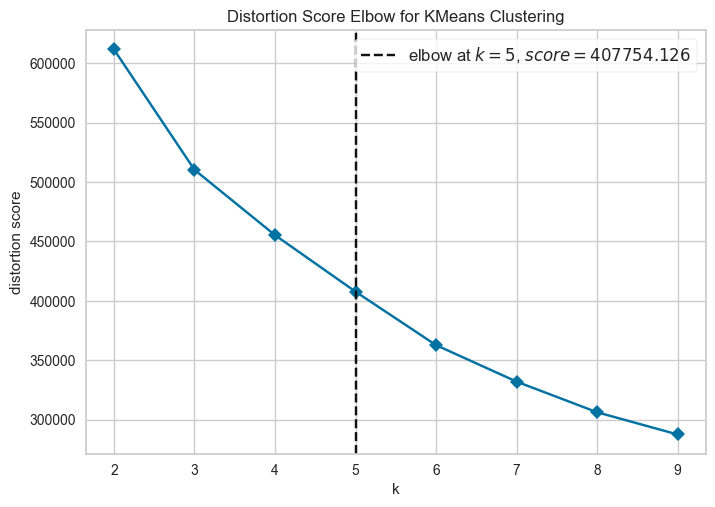

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
visualizer = KElbowVisualizer(KMeans(random_state=PARAMS["SEED"]), k=(2,10), timings=False)
visualizer.fit(X_transformed)
visualizer.show()

In [6]:
n_clusters_kmeans = visualizer.elbow_value_

#### GaussianMixture

In [7]:
n_components = range(1, 11)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = PARAMS["SEED"])
        gmm.fit(X_transformed)
        score.append((cov,n_comp,gmm.bic(X_transformed)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
39,full,10,-965921.288378


In [8]:
n_components_gauss = score_2.head(n=2).N_Components.values[0]

#### DBSCAN

0.4984019064914824


<Figure size 500x500 with 0 Axes>

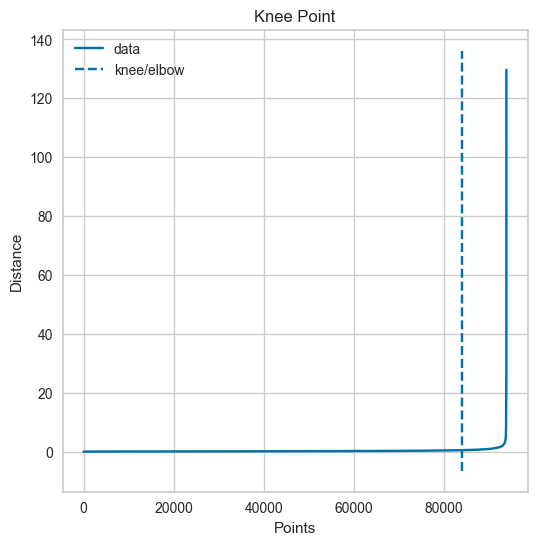

In [9]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_transformed)
distances, indices = neighbors.kneighbors(X_transformed)
distances = np.sort(distances[:,10], axis=0)


i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [10]:
eps_dbscan = distances[knee.knee]

### MLFlow

In [11]:
ESTIMATOR_PARAMS = {
    "DBSCAN": {
        "estimator": DBSCAN,
        "params": {"eps": eps_dbscan, "min_samples": 2}
    },
    "KMeans": {
        "estimator": KMeans,
        "params": {"n_clusters": n_clusters_kmeans, "random_state": PARAMS["SEED"]}
    },
    "GaussianMixture": {
        "estimator": GaussianMixture,
        "params": {"n_components": n_components_gauss, "random_state": PARAMS["SEED"]}
    }
}

In [12]:
experiment_name = PARAMS["EXPERIMENT_NAME"]
mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

In [13]:
for model_name, model_config in ESTIMATOR_PARAMS.items():
    estimator = model_config["estimator"]
    params = model_config["params"]

    with mlflow.start_run(run_name=f"{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}-RFM-Segmentation-{model_name}",
                            experiment_id=experiment_id,
                            tags={"version": "v1", "priority": "P1"},
                            description="RFM segmentation modeling",
                            ) as mlf_run:
        logger.info(f"run_id: {mlf_run.info.run_id}")
        logger.info(f"version tag value: {mlf_run.data.tags.get('version')}")

        mlflow.log_params(params)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('estimator', estimator(**params))
        ])

        pipeline.fit(X)

        # Predict cluster labels
        if hasattr(pipeline.named_steps['estimator'], 'labels_'):
            labels = pipeline.named_steps['estimator'].labels_
        else:
            labels = pipeline.predict(X)

        # Calculate and log metrics
        if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            mlflow.log_metric("silhouette_score", silhouette)
            mlflow.log_metric("calinski_harabasz_score", calinski_harabasz)
            mlflow.log_metric("davies_bouldin_score", davies_bouldin)

        logger.info(f"Estimator: {pipeline[-1].__class__.__name__}")
        logger.info(f"Silhouette Score: {silhouette} --- Calinski Score: {calinski_harabasz} --- Davies Score: {davies_bouldin}")

        # Log the model
        signature = infer_signature(X, labels)

        mlflow.sklearn.log_model(pipeline, artifact_path=model_name, signature=signature, input_example=X[:5], registered_model_name=f"segmentation-olist-{model_name}")

        logger.info(f"Entrainement de {model_name} terminé et journalisé sur MLlow")

2024-08-09 16:18:26.452 | INFO     | __main__:<module>:10 | Thread: MainThread | PID: 49869 - run_id: ebd8f7a115da4579ae70b3c02161678a
2024-08-09 16:18:26.453 | INFO     | __main__:<module>:11 | Thread: MainThread | PID: 49869 - version tag value: v1
2024-08-09 16:20:07.855 | INFO     | __main__:<module>:39 | Thread: MainThread | PID: 49869 - Estimator: DBSCAN
2024-08-09 16:20:07.860 | INFO     | __main__:<module>:40 | Thread: MainThread | PID: 49869 - Silhouette Score: -0.8421570639054003 --- Calinski Score: 41.27951500707827 --- Davies Score: 3.1809868706252424
2024/08/09 16:20:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'segmentation-olist-DBSCAN' already exists. Creating a new version of this model...
Created version '5' of model 'segmentation-olist-DBSCAN'.
2024-08-09 16:20:10.812 | INFO     | __main__:<module>:47 | Thread: MainThread | PID: 49869 - Entrainement de DBSCAN terminé et journalisé sur MLlow
2024-

En comparant les résultats obtenus, nous pouvons voir que le modèle KMeans présente les meilleurs performances avec le plus haut silhouette_socre et calinski_harabasz_score bien que le modèle DBSCAN présente un plus faible davies_bouldin_score</br>
Nous allons donc  sauvegarder et utiliser ce modèle dans la suite

In [14]:
model_name = "segmentation-olist-KMeans"
client = MlflowClient()
latest_version = client.get_latest_versions(model_name, stages=["None"])[0].version
model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{latest_version}")

In [15]:
with open(f'{OUTPUTS_DIR}/olist-kmeans-current.pkl', 'wb') as file:
    pickle.dump(model, file)

with open(f'{API_DIR}/models/olist-kmeans-current.pkl', 'wb') as file:
    pickle.dump(model, file)

### Interprétation des segments

In [16]:
with open(f'{OUTPUTS_DIR}/olist-kmeans-current.pkl', 'rb') as file:
    model = pickle.load(file)

In [17]:
model

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('estimator', KMeans(n_clusters=5, random_state=42))])

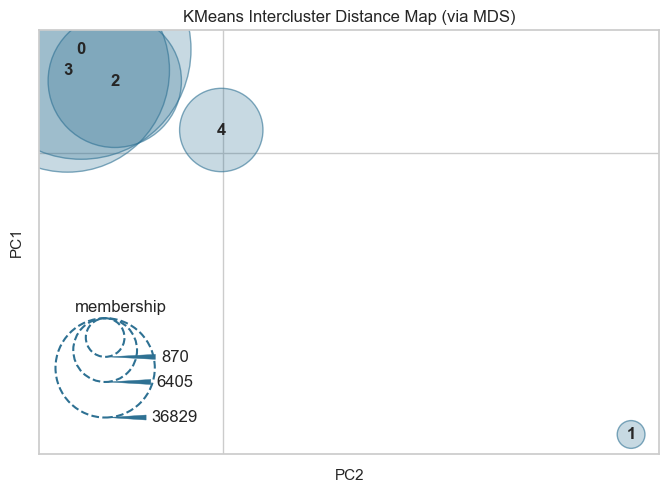

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [18]:
visualizer = InterclusterDistance(KMeans(n_clusters=n_clusters_kmeans, random_state=PARAMS["SEED"]))
visualizer.fit(X)
visualizer.show()

In [19]:
df_seg_kmeans = df_rfm.copy()
df_seg_kmeans['segments'] = model.predict(X)
df_seg_kmeans.head()

,customer_unique_id,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,segments
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,8.0,1.0,1.092379,115,0.056378,12.00,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,1.0,1.0,1.438624,118,0.036778,8.29,4
2,0000f46a3911fa3c0805444483337064,69.00,1,8.0,1.0,1.249565,541,0.092786,17.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,4.0,1.0,1.678338,325,0.091701,17.63,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,6.0,1.0,1.093833,292,0.030474,16.89,1


In [20]:
df_seg_kmeans.to_csv(f"{API_DIR}/data/segmentation_kmeans_result.csv", index=False)

In [21]:
df_analysis = df_seg_kmeans.groupby('segments').mean()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value
segments,,,,,,,,
0,110.634750,1.120612,1.821361,1.186958,1.374357,391.859870,0.018300,19.877196
1,114.649922,1.043548,6.545977,1.073587,1.356946,257.686693,0.062378,19.794447
2,697.614984,7.133441,3.541767,21.368167,7.418621,230.554662,0.003029,152.128424
3,540.072907,2.225655,5.081877,3.392778,2.177333,229.376483,0.008686,66.466257
4,107.202166,1.107699,1.721428,1.168824,1.376395,129.715212,0.017734,20.278010


In [22]:
df_analysis['#observations'] = df_seg_kmeans[['segments','frequency']].groupby(['segments']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,#observations,Percentage
segments,,,,,,,,,,
0,110.634750,1.120612,1.821361,1.186958,1.374357,391.859870,0.018300,19.877196,28231,0.300935
1,114.649922,1.043548,6.545977,1.073587,1.356946,257.686693,0.062378,19.794447,16878,0.179915
2,697.614984,7.133441,3.541767,21.368167,7.418621,230.554662,0.003029,152.128424,622,0.006630
3,540.072907,2.225655,5.081877,3.392778,2.177333,229.376483,0.008686,66.466257,7671,0.081771
4,107.202166,1.107699,1.721428,1.168824,1.376395,129.715212,0.017734,20.278010,40409,0.430749


In [23]:
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,#observations,Percentage
segments,,,,,,,,,,
0,110.634750,1.120612,1.821361,1.186958,1.374357,391.859870,0.018300,19.877196,28231,0.300935
1,114.649922,1.043548,6.545977,1.073587,1.356946,257.686693,0.062378,19.794447,16878,0.179915
2,697.614984,7.133441,3.541767,21.368167,7.418621,230.554662,0.003029,152.128424,622,0.006630
3,540.072907,2.225655,5.081877,3.392778,2.177333,229.376483,0.008686,66.466257,7671,0.081771
4,107.202166,1.107699,1.721428,1.168824,1.376395,129.715212,0.017734,20.278010,40409,0.430749


## Interprétation des segments et recommandations marketing

**Segment 0 : Clients occasionnels avec faible dépense moyenne**
- **Description :** Ce segment se distingue par une dépense totale relativement faible (110.63), une fréquence d'achat basse (1.12), et un faible nombre d'articles achetés en moyenne (1.19). Leurs achats sont peu récents (391.86 jours), et leur valeur de fret est également basse (19.88).
- **Actions Marketing :**
  - **Réengagement :** Lancer des campagnes de réactivation ciblées, comme des offres promotionnelles ou des remises spéciales pour encourager ces clients à revenir.
  - **Communication personnalisée :** Envoyer des emails ou des notifications pour rappeler à ces clients l'existence de la marque et proposer des produits qui correspondent à leurs précédents achats.
  - **Programmes de fidélité :** Introduire un programme de fidélité qui incite ces clients à augmenter leur fréquence d'achat et leur panier moyen.


**Segment 1 : Clients achetant principalement en plusieurs fois avec faible fréquence**
- **Description :** Ces clients dépensent un montant modéré (114.65) mais leur fréquence d'achat est relativement faible (1.04). Ils optent souvent pour des paiements en plusieurs fois (6.55 en moyenne) et achètent peu d'articles (1.07). Leur activité est assez récente (257.69 jours) et leur valeur de fret est modeste (19.79).
- **Actions Marketing :**
  - **Offres sur les paiements fractionnés :** Promouvoir des options de paiement fractionné avec des conditions avantageuses pour attirer ces clients.
  - **Ciblage de produits complémentaires :** Proposer des produits complémentaires ou accessoires pour augmenter leur panier moyen à chaque achat.
  - **Campagnes de relance :** Envoyer des rappels et des offres limitées dans le temps pour les inciter à acheter plus fréquemment.

**Segment 2 : Clients à haute valeur avec achats fréquents et importants**
- **Description :** Ce segment est constitué de clients à haute valeur avec la dépense totale la plus élevée (697.61) et la fréquence d'achat la plus élevée (7.13). Ils achètent de nombreux articles (21.37) et leur valeur de fret est également la plus élevée (152.13). Ces clients sont relativement récents (230.55 jours).
- **Actions Marketing :**
  - **Programme VIP :** Mettre en place un programme exclusif avec des avantages premium pour récompenser et retenir ces clients de grande valeur.
  - **Service client personnalisé :** Offrir un service dédié pour répondre rapidement à leurs besoins et maintenir leur satisfaction.
  - **Accès en avant-première :** Proposer un accès prioritaire aux nouveaux produits ou ventes pour stimuler leur engagement continu.

**Segment 3 : Clients réguliers avec paniers d’achat moyens**
- **Description :** Ces clients ont une dépense totale relativement élevée (540.07) et achètent régulièrement (2.23 fois en moyenne). Ils achètent un nombre modéré d'articles (3.39) avec une valeur de fret assez élevée (66.47). Leur activité est également récente (229.38 jours).
- **Actions Marketing :**
  - **Offres groupées :** Proposer des offres groupées ou des réductions sur les achats multiples pour encourager ces clients à acheter davantage lors de chaque commande.
  - **Emails de recommandation :** Envoyer des recommandations personnalisées basées sur leurs précédents achats pour augmenter la fréquence d'achat.
  - **Programmes de fidélité :** Mettre en avant les avantages du programme de fidélité pour les inciter à continuer d'acheter régulièrement.

**Segment 4 : Clients récents et peu engagés**
- **Description :** Ce segment comprend des clients avec une dépense totale faible (107.20) et une fréquence d'achat basse (1.11). Ils achètent peu d'articles (1.17) mais sont assez récents dans leur engagement (129.71 jours). Leur valeur de fret est également faible (20.28).
- **Actions Marketing :**
  - **Offres de bienvenue :** Lancer des campagnes de bienvenue pour ces clients récents avec des offres spéciales pour les inciter à effectuer de nouveaux achats.
  - **Communication proactive :** Maintenir un contact régulier avec des suggestions de produits personnalisés pour les engager davantage.
  - **Récompenses pour achat récurrent :** Proposer des remises ou des avantages supplémentaires pour encourager ces clients à acheter plus fréquemment.